# Seasonal Impacts on a Coastal Environment

This tutorial uses multiple satellite data products to analyze the relationships between river height, land water equivalent thickness, sea surface salinity, and sea surface temperature in the Amazon river basin’s estuary and coastal region. 
The contents are useful for both the ocean and terrestrial hydrosphere disciplines, showcasing how to use on-premises and cloud datasets, existing cloud services and functionalities, and Earthdata User Interface (UI) and Application Programming Interfaces (API). 

## Datasets
The tutorial itself will use fives missions, and a total of five different datasets, a combination of cloud and on premises datasets: 

   1. **TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2** 
    
    [DOI]{dx.doi.org/10.5067/TEMSC-3JC62} 
   
    The Gravity Recovery And Climate Experiment Follow-On (GRACE-FO) satellite land water equivalent (LWE) thicknesses will be used to observe seasonal changes in water storage around the river. When discharge is high, the change in water storage will increase, thus highlighting a wet season. 


   2. **PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2** 

    [DOI]{dx.doi.org/10.5067/PSGRA-DA2V2}
   
    The NASA Pre-SWOT Making Earth System Data Records for Use in Research Environments (MEaSUREs) Program virtual gauges will be used as a proxy for Surface Water and Ocean Topography (SWOT) discharge until SWOT products are available. MEaSUREs contains river height products, not discharge, but river height is directly related to discharge and thus will act as a good substitute.


   3. **SMAP_JPL_L3_SSS_CAP_MONTHLY_V5** 
    
    [DOI]{dx.doi.org/10.5067/SMP50-3TMCS} 
   
    Sea surface salinity is obtained from the Soil Moisture Active Passive (SMAP) satellite (2015-2019).

   
   4. **AQUARIUS_L3_SSS-RainFlagged_SMI_DAILY_V5**
    
    [DOI]{dx.doi.org/10.5067/AQR50-3Y1CE}
    
    Sea surface salinity is obtained from the Aquarius/SAC-D satellite (2011-2015).

   
   5. **MODIS_AQUA_L3_SST_MID-IR_MONTHLY_9KM_NIGHTTIME_V2019.0**
   
    [DOI]{dx.doi.org/10.5067/MODAM-MO9N9} 
    
    Sea surface temperature is obtained from the Moderate Resolution Imaging Spectrometer (MODIS) instrument on board the Aqua satellite. 

The tutorial will show exactly how all the datasets are accessed and subset for our specific location, the Amazon River basin estuary. Graphs and images of river height (river discharge when SWOT data is available), LWE thickness, salinity, and sea surface temperature will be formulated and shown side by side to see relationships between the data.

## Needed Packages

In [1]:
import time
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy
import zarr
import s3fs
from json import dumps, loads
import json
from IPython.display import HTML
from os.path import isfile, basename, abspath

## Set the CMR, URS, and Harmony endpoints

In [2]:
cmr = "cmr.earthdata.nasa.gov"
urs = "urs.earthdata.nasa.gov"
harmony = "harmony.earthdata.nasa.gov"

cmr, urs, harmony

('cmr.earthdata.nasa.gov',
 'urs.earthdata.nasa.gov',
 'harmony.earthdata.nasa.gov')

## NASA Earthdata Login Setup

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

The setup_earthdata_login_auth function will allow Python scripts to log into any Earthdata Login application programmatically. To avoid being prompted for credentials every time you run and also allow clients such as curl to log in, you can add the following to a .netrc (_netrc on Windows) file in your home directory:

```shell 
    machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating "netrc access too permissive."

```shell
$ chmod 0600 ~/.netrc
```

*You will be prompted for your username and password if you dont have a netrc file. Note: these imports are all in the Python 3.6+ standard library.*


In [3]:
from platform import system
from netrc import netrc
from getpass import getpass
from urllib import request
from http.cookiejar import CookieJar
from os.path import join, expanduser

TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_earthdata_login_auth(urs: str='urs.earthdata.nasa.gov', cmr: str='cmr.earthdata.nasa.gov'):

    # GET URS LOGIN INFO FROM NETRC OR USER PROMPTS:
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(urs)
        print("# Your URS credentials were securely retrieved from your .netrc file.")
    except (FileNotFoundError, TypeError):
        print('# Please provide your Earthdata Login credentials for access.')
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (urs))
        username = input('Username: ')
        password = getpass('Password: ')

    # SET UP URS AUTHENTICATION FOR HTTP DOWNLOADS:
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, urs, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

    # GET TOKEN TO ACCESS RESTRICTED CMR METADATA:
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    r = requests.post(
        url="https://%s/legacy-services/rest/tokens" % cmr,
        data=TOKEN_DATA % (str(username), str(password), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    )
    return r.json()['token']['id']


# Provide URS credentials for HTTP download auth & CMR token retrieval:
_token = setup_earthdata_login_auth(urs=urs, cmr=cmr)

# Your URS credentials were securely retrieved from your .netrc file.


### Cloud data: GRACE Liquid Water Equivalent (LWE)
#### Search for GRACE LWE Thickness data
GRACE/GRACE-FO data can be obtained from the cloud.

Suppose we are interested in LWE data from the dataset (DOI:10.5067/TEMSC-3JC62) described on this PO.DAAC dataset landing page: 
https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2

From the landing page, we see the dataset Short Name under the Information tab. Copy that to paste and search later.

Log in to your Earthdata account at:
https://search.earthdata.nasa.gov

Enter the Short Name and search. Clicking on one of the search results brings us to a list of granules. Within that URL, we can grab the concept-id, a string starting with "C" and ending with "-POCLOUD". For this dataset, it is "C1938032626-POCLOUD".

#### Collection search in CMR
Here we use the requests library to search in *collections* by either short name or concept-id, which returns exactly one dataset, or one "hit", in a JSON format.

In [4]:
grace_ShortName = "TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2"
r = requests.get(url=f"https://{cmr}/search/collections.umm_json",
                params = 
                 {
                     'provider': "POCLOUD",
                     'token': _token,
                     'concept-id': "C1938032626-POCLOUD"
                     #'ShortName': grace_ShortName,
                 }
                
                )
grace_coll = r.json()
grace_coll['hits']

1

#### See collection metadata

In [5]:
grace_coll_meta = grace_coll['items'][0]['meta']
grace_coll_meta

{'revision-id': 3,
 'deleted': False,
 'format': 'application/vnd.nasa.cmr.umm+json',
 'provider-id': 'POCLOUD',
 'user-id': 'chen5510',
 'has-formats': False,
 'has-spatial-subsetting': False,
 'native-id': 'JPL+GRACE+and+GRACE-FO+Mascon+Ocean,+Ice,+and+Hydrology+Equivalent+Water+Height+Coastal+Resolution+Improvement+(CRI)+Filtered+Release+06+Version+02',
 'has-transforms': False,
 'has-variables': False,
 'concept-id': 'C1938032626-POCLOUD',
 'revision-date': '2021-04-19T17:26:51.036Z',
 'granule-count': 0,
 'has-temporal-subsetting': False,
 'concept-type': 'collection'}

#### Granule search
Here we use the requests library to search for *granules* in the collection. It returns 7 "hits", or 7 granules.

In [6]:
r = requests.get(url=f"https://{cmr}/search/granules.umm_json", 
                 params={'provider': "POCLOUD", 
                         'ShortName': grace_ShortName, 
                         'token': _token})

grace_gran = r.json()
grace_gran['hits']

8

#### For GRACE, when there are multiple granules, take the latest monthly granule (automate finding of most recent month?)

In [7]:
latest_granule = grace_gran['hits']-1 # If not true, then sort grace_gran by 'native-id'
grace_gran['items'][latest_granule]['meta']

{'concept-type': 'granule',
 'concept-id': 'G2050191643-POCLOUD',
 'revision-id': 1,
 'native-id': 'GRCTellus.JPL.200204_202103.GLO.RL06M.MSCNv02CRI',
 'provider-id': 'POCLOUD',
 'format': 'application/vnd.nasa.cmr.umm+json',
 'revision-date': '2021-05-11T03:30:34.686Z'}

#### Get download link
The download link to the .nc file is one of the the RelatedURLs.

In [8]:
grace_gran['items'][latest_granule]['umm']['RelatedUrls']

[{'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202103.GLO.RL06M.MSCNv02CRI.nc.md5',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202103.GLO.RL06M.MSCNv02CRI.cmr.json',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202103.GLO.RL06M.MSCNv02CRI.nc',
  'Type': 'GET DATA',
  'Description': 'File to download'}]

In [9]:
# From above, select the link to the .nc file (links are not always listed in the same order)
link_num = 2
grace_url = grace_gran['items'][latest_granule]['umm']['RelatedUrls'][link_num]['URL']
grace_url

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202103.GLO.RL06M.MSCNv02CRI.nc'

#### Download the .nc file from the cloud
And display overview of contents using ncdump.

In [10]:
r = requests.get(grace_url)
with open('iosos_demo_GRACEFO.nc', 'wb') as f:
    f.write(r.content)

!ncdump -h iosos_demo_GRACEFO.nc

netcdf iosos_demo_GRACEFO {
dimensions:
	lon = 720 ;
	lat = 360 ;
	time = 195 ;
	bounds = 2 ;
variables:
	double lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "longitude" ;
		lon:standard_name = "longitude" ;
		lon:axis = "X" ;
		lon:valid_min = 0.25 ;
		lon:valid_max = 359.75 ;
		lon:bounds = "lon_bounds" ;
	double lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "latitude" ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
		lat:valid_min = -89.75 ;
		lat:valid_max = 89.75 ;
		lat:bounds = "lat_bounds" ;
	double time(time) ;
		time:units = "days since 2002-01-01T00:00:00Z" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:axis = "T" ;
		time:calendar = "gregorian" ;
		time:bounds = "time_bounds" ;
	double lwe_thickness(time, lat, lon) ;
		lwe_thickness:units = "cm" ;
		lwe_thickness:long_name = "Liquid_Water_Equivalent_Thickness" ;
		lwe_thickness:standard_name = "Liquid_Water_Equivalent_Thickness" ;
		lwe_thickness:coordinates = "tim

#### Open file using xarray.

In [11]:
ds_GRACE = xr.open_dataset('iosos_demo_GRACEFO.nc')
ds_GRACE

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 195)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-03-16T1...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2021-04-27T21:04:06Z

#### Plot a subset of the data
Use the function xarray.DataSet.sel to select a subset of the data to plot. 

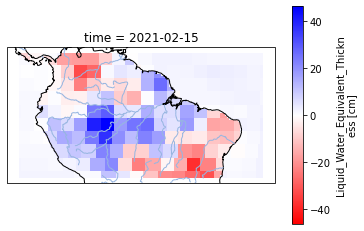

In [12]:
lat_bnds, lon_bnds = [-18, 10], [275, 330] #degrees east for longitude
ds_GRACE_subset = ds_GRACE.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))
ds_GRACE_subset

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.RIVERS)
ds_GRACE_subset.lwe_thickness[193,:,:].plot(cmap = 'bwr_r') #106: July 2011
plt.show()

### On-premise data via OPeNDAP: River heights
Use xarray and OPeNDAP link to see an overview of the dataset

Currently, Pre-SWOT MEaSUREs data do not have the tools required to access them on the cloud, but methods are in the works! We will obtain this dataset using OPeNDAP. OPeNDAP provides an API on the host server to access data without downloading it. OPeNDAP will also have a cloud component in the future though so this method of access can be both on-prem and cloud-based moving forward. 

To find the OPeNDAP links needed to open the data using the python package xarray, go to the specific satellite's page on PO.DAAC (ex. Pre-SWOT MEaSUREs's site: https://podaac.jpl.nasa.gov/MEaSUREs-Pre-SWOT?sections=about%2Bdata) 

Click on the dataset you want (e.g. https://podaac.jpl.nasa.gov/dataset/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2) and click the "Data Access" tab. This will give you a link to where you can find the data in OPeNDAP (ex. https://podaac-opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/). 

From there, navigate to the desired NetCDF file and copy it's link (ex. for MEaSUREs, we want the Amazon estuary, so we choose the South America Amazon file: https://opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/South_America_Amazon1kmdaily.nc).

The guidebook explains the details of the Pre-SWOT MEaSUREs data:
https://podaac-tools.jpl.nasa.gov/drive/files/allData/preswot_hydrology/L2/rivers/docs/GRRATS_user_handbookV2.pdf

Our desired variable is height (meters above EGM2008 geoid) for this exercise, which can be subset by distance and time. Distance represents the distance from the river mouth, in this example, the Amazon estuary. Time is between April 8, 1993 and April 20, 2019.

Let's look at this example file to see how the data is organized:

In [13]:
ds_MEaSUREs = xr.open_dataset('https://opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/South_America_Amazon1kmdaily.nc')
ds_MEaSUREs

<xarray.Dataset>
Dimensions:   (X: 3311, Y: 3311, charlength: 26, distance: 3311, time: 9469)
Coordinates:
  * time      (time) datetime64[ns] 1993-04-08T15:20:40.665117184 ... 2019-04...
Dimensions without coordinates: X, Y, charlength, distance
Data variables:
    lon       (X) float64 ...
    lat       (Y) float64 ...
    FD        (distance) float64 ...
    height    (distance, time) float64 ...
    sat       (charlength) |S64 ...
    storage   (distance, time) float64 ...
    LakeFlag  (distance) float64 ...
    IceFlag   (time) float64 ...
Attributes: (12/40)
    title:                         GRRATS (Global River Radar Altimetry Time ...
    Conventions:                   CF-1.6, ACDD-1.3
    institution:                   Ohio State University, School of Earth Sci...
    source:                        MEaSUREs OSU Storage toolbox 2018
    keywords:                      EARTH SCIENCE,TERRESTRIAL HYDROSPHERE,SURF...
    keywords_vocabulary:           Global Change Master Directory (GCMD)
    ...                            ...
    geospatial_lat_max:            -0.6550700975069503
    geospatial_lat_units:          degree_north
    geospatial_vertical_max:       92.7681246287056
    geospatial_vertical_min:       -3.563409518163376
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up

### On-premise data via OPeNDAP: sea surface salinity (SMAP and Aquarius) and temperature (MODIS)

Pre-SWOT MEaSUREs data resides in one NetCDF file for the whole time period, but the same cannot be said for SMAP, Aquarius and MODIS data. They have one file per month for their monthly datasets. SMAP has data from April 2015 - present, Aquarius has data from August 2011 - June 2015, and MODIS has the entire 2011-2019 time period.

First, we create strings of OPeNDAP links in lists for each satellite product so we can obtain them and merge them into one file. The links change depending on the date, so the pattern of how the links change needs to be observed and then looped over and appended to the links file list. For example, SMAP has month and year numbers in its links, while Aquarius has start day and end day of the year in its links, so writing their strings takes different logic.

In [14]:
# Initialize SMAP file list
file_list_SMAP = []
#create an array of the months of the year and an array for the years
counter_month = np.arange(1,13)
counter_year = np.arange(2015, 2020)

# Make list of file paths
for j in counter_year:
    for i in counter_month:
        if j == 2015: #data starts in april for 2015
            if i > 3:
                if i < 10:        #for single digit months, only one number needs to be changed
                    file_list_SMAP.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/%d/SMAP_L3_SSS_%d0%d_MONTHLY_V5.0.nc' % (j, j, i))
                else:             #for double digit months, 2 numbers in the string need to change
                    file_list_SMAP.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/%d/SMAP_L3_SSS_%d%d_MONTHLY_V5.0.nc' % (j, j, i))
        else:
            if i < 10:        #for single digit months, only one number needs to be changed
                file_list_SMAP.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/%d/SMAP_L3_SSS_%d0%d_MONTHLY_V5.0.nc' % (j, j, i))
            else:             #for double digit months, 2 numbers in the string need to change
                file_list_SMAP.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/%d/SMAP_L3_SSS_%d%d_MONTHLY_V5.0.nc' % (j, j, i))

# Initialize Aquarius file list
file_list_Aq = []
# Create an array of the months of the year and an array for the years
counter_month = np.arange(0,12)
counter_year = np.arange(2011, 2016)

# Make list of file paths
for j in counter_year:
    for i in counter_month:
        if j == 2012: #leap-year
            d1 = ['001', '032', '061', '092', '122', '153', '183', '214', '245', '275', '306', '336']
            d2 = ['031', '060', '091', '121', '152', '182', '213', '244', '274', '305', '335', '366']
        else: #all other years
            d1 = ['001', '032', '060', '091', '121', '152', '182', '213', '244', '274', '305', '335']
            d2 = ['031', '059', '090', '120', '151', '181', '212', '243', '273', '304', '334', '365']
        
        if j == 2011: #data starts in the 8th month (index 7)
            if i > 6:
                file_list_Aq.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/aquarius/L3/mapped/V5/monthly/SCI/%d/Q%d%s%d%s.L3m_MO_SCI_V5.0_SSS_1deg.bz2' % (j, j, d1[i], j, d2[i]))
        elif j == 2015: #data ends in the 6th month (index 5)
            if i < 6:
                file_list_Aq.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/aquarius/L3/mapped/V5/monthly/SCI/%d/Q%d%s%d%s.L3m_MO_SCI_V5.0_SSS_1deg.bz2' % (j, j, d1[i], j, d2[i]))
        else:
            file_list_Aq.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/aquarius/L3/mapped/V5/monthly/SCI/%d/Q%d%s%d%s.L3m_MO_SCI_V5.0_SSS_1deg.bz2' % (j, j, d1[i], j, d2[i]))

        
# Initialize MODIS file list for sea surface temperature
file_list_MODIS = []
# Create an array of the months of the year and an array for the years
counter_month = np.arange(0,12)
counter_year = np.arange(2011, 2020)

# Make list of file paths
for j in counter_year:
    for i in counter_month:
        if j == 2012 or j == 2016: #leap-year
            d1 = ['0101', '0201', '0301', '0401', '0501', '0601', '0701', '0801', '0901', '1001', '1101', '1201']
            d2 = ['0131', '0229', '0331', '0430', '0531', '0630', '0731', '0831', '0930', '1031', '1130', '1231']
        else: #all other years
            d1 = ['0101', '0201', '0301', '0401', '0501', '0601', '0701', '0801', '0901', '1001', '1101', '1201']
            d2 = ['0131', '0228', '0331', '0430', '0531', '0630', '0731', '0831', '0930', '1031', '1130', '1231']
        
        if j == 2011: #data starts in the 8th month (index 7)
            if i > 6:
                file_list_MODIS.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/%d/AQUA_MODIS.%d%s_%d%s.L3m.MO.SST4.sst4.9km.nc' % (j, j, d1[i], j, d2[i]))
        elif j == 2019: #data ends in the 11th month (index 10)
            if i < 11:
                file_list_MODIS.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/%d/AQUA_MODIS.%d%s_%d%s.L3m.MO.SST4.sst4.9km.nc' % (j, j, d1[i], j, d2[i]))
        else:
            file_list_MODIS.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/%d/AQUA_MODIS.%d%s_%d%s.L3m.MO.SST4.sst4.9km.nc' % (j, j, d1[i], j, d2[i]))

# Un comment to see links lists
# file_list_SMAP
# file_list_Aq
file_list_MODIS

['https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/2011/AQUA_MODIS.20110801_20110831.L3m.MO.SST4.sst4.9km.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/2011/AQUA_MODIS.20110901_20110930.L3m.MO.SST4.sst4.9km.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/2011/AQUA_MODIS.20111001_20111031.L3m.MO.SST4.sst4.9km.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/2011/AQUA_MODIS.20111101_20111130.L3m.MO.SST4.sst4.9km.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/2011/AQUA_MODIS.20111201_20111231.L3m.MO.SST4.sst4.9km.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/2012/AQUA_MODIS.20120101_20120131.L3m.MO.SST4.sst4.9km.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/mont

In [15]:
# For OPeNDAP, we need to set the number of files that can be open at once to 10, 
# So that xa.open_mfdataset() actually reads all links (see https://github.com/pydata/xarray/issues/4082)
xr.set_options(file_cache_maxsize=10)

# To use xa.open_mfdataset which combines netCDF files
ds_SMAP = xr.open_mfdataset(file_list_SMAP, combine='by_coords')
ds_SMAP

<xarray.Dataset>
Dimensions:               (latitude: 720, longitude: 1440, time: 57)
Coordinates:
  * latitude              (latitude) float32 89.88 89.62 89.38 ... -89.62 -89.88
  * longitude             (longitude) float32 -179.9 -179.6 ... 179.6 179.9
  * time                  (time) datetime64[ns] 2015-04-16 ... 2019-12-16T12:...
Data variables:
    smap_sss              (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    anc_sss               (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    anc_sst               (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    smap_spd              (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    smap_high_spd         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    weight                (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    land_fraction         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ice_fraction          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    smap_sss_uncertainty  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/38)
    title:                       SMAP 0.25x0.25 deg grid averaged monthly SSS...
    institution:                 Jet Propulsion Laboratory
    source:                      SMAP L2B SSS
    history:                     DATA_SOURCE_VERSION V5.0 L2B SMAP SSS/WSPD
    comment:                     Gaussian-weighted map gridding of SMAP L2B S...
    Gaussian_window_radius:      45.0
    ...                          ...
    creator_name:                JPL
    creator_email:               fore@jpl.nasa.gov
    publisher_name:              Alexander G. Fore
    publisher_email:             fore@jpl.nasa.gov
    contributor_name:            Alexander Fore, Simon Yueh, Wenqing Tang, Ak...
    references:                  10.1109/TGRS.2016.2601486, 10.1109/TGRS.2016...

In [16]:
# #for OPeNDAP, we need to set the number of files that can be open at once to 10, 
# #so that xr.open_mfdataset() actually reads all links (see https://github.com/pydata/xarray/issues/4082)
# xr.set_options(file_cache_maxsize=10)

# #to use xr.open_mfdataset which combines netCDF files
ds_MODIS = xr.open_mfdataset(file_list_MODIS, combine='nested', concat_dim='time')
ds_MODIS

<xarray.Dataset>
Dimensions:    (eightbitcolor: 256, lat: 2160, lon: 4320, rgb: 3, time: 100)
Coordinates:
  * lat        (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon        (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: eightbitcolor, rgb, time
Data variables:
    palette    (time, rgb, eightbitcolor) int8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
    sst4       (time, lat, lon) float32 dask.array<chunksize=(1, 2160, 4320), meta=np.ndarray>
    qual_sst4  (time, lat, lon) float32 dask.array<chunksize=(1, 2160, 4320), meta=np.ndarray>
Attributes: (12/59)
    product_name:                     AQUA_MODIS.20110801_20110831.L3m.MO.SST...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    temporal_range:                   month
    ...                               ...
    publisher_url:                    https://oceandata.sci.gsfc.nasa.gov
    processing_level:                 L3 Mapped
    cdm_data_type:                    grid
    data_bins:                        Attribute edlided: Unsupported attribut...
    data_minimum:                     -1.665
    data_maximum:                     35.065

In [17]:
#open and combine Aquarius files into 1 .nc file
xr.set_options(file_cache_maxsize=10)
#to use xa.open_mfdataset which combines netCDF files
ds_Aq = xr.open_mfdataset(file_list_Aq, combine='nested', concat_dim='time')
ds_Aq

<xarray.Dataset>
Dimensions:      (SSS_0: 180, SSS_1: 360, SSS_ran_unc_0: 180, SSS_ran_unc_1: 360, SSS_sys_unc_0: 180, SSS_sys_unc_1: 360, palette_0: 3, palette_1: 256, time: 47)
Dimensions without coordinates: SSS_0, SSS_1, SSS_ran_unc_0, SSS_ran_unc_1, SSS_sys_unc_0, SSS_sys_unc_1, palette_0, palette_1, time
Data variables:
    SSS          (time, SSS_0, SSS_1) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    SSS_ran_unc  (time, SSS_ran_unc_0, SSS_ran_unc_1) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    SSS_sys_unc  (time, SSS_sys_unc_0, SSS_sys_unc_1) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    palette      (time, palette_0, palette_1) int8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/68)
    product_name:                      Q20112132011243.L3m_MO_SCI_V5.0_SSS_1deg
    instrument:                        Aquarius
    title:                             Aquarius Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          SAC-D Aquarius
    temporal_range:                    MO
    ...                                ...
    identifier_product_doi:            http://dx.doi.org
    keywords:                          SURFACE SALINITY, SALINITY, AQUARIUS, ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    software_name:                     smigen
    software_version:                  5.20
    source:                            Q20112132011243.L3b_MO_SCI_V5.0.main

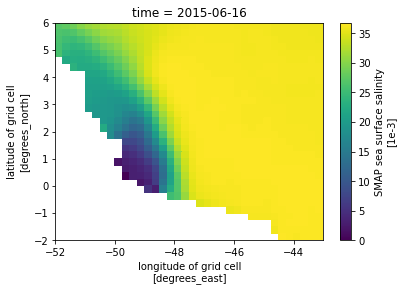

In [18]:
#SMAP
lat_bnds, lon_bnds = [6, -2], [-52, -43] #switched lat directions from GRACE, and longitude has positives and negatives
ds_SMAP_subset = ds_SMAP.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
#ds_SMAP_subset

#plot SMAP subset
ds_SMAP_subset.smap_sss[2,:,:].plot() #at time '2', indicating June 2015

plt.show()

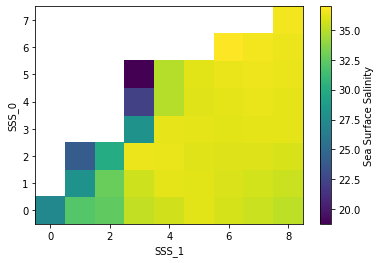

In [19]:
#Aquarius
lat_bnds, lon_bnds = [84, 92], [128, 137] #See how commented out plot is distorted, only positive numbers
ds_Aq_subset = ds_Aq.sel(SSS_0=slice(*lat_bnds), SSS_1=slice(*lon_bnds))
#ds_Aq_subset

#plot Aquarius subset
#this map is inverted compared to SMAP, but still capturing the same area
ds_Aq_subset.SSS[10,:,:].plot() #at time '10' indicating June 2012
#ds_Aq.SSS[10,:,:].plot() #whole world map view to see the inversion of the data

plt.show()

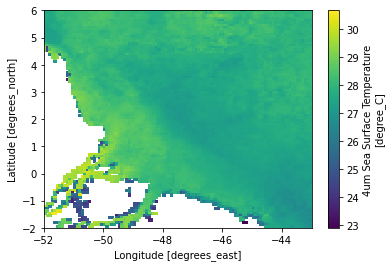

In [20]:
#MODIS SST
lat_bnds, lon_bnds = [6, -2], [-52, -43] #like SMAP
ds_MODIS_subset = ds_MODIS.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))
#ds_MODIS_subset

#plot MODIS subset
ds_MODIS_subset.sst4[2,:,:].plot() #at time '2', indicating Oct 2011

plt.show()

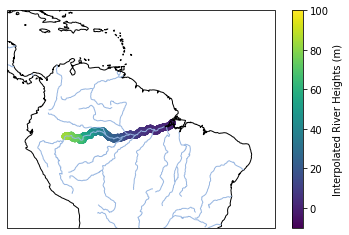

In [21]:
#Plotting the river distances and associated heights on the map at time t=9069 (March 16, 2018)
#Change the extent to capture the data of the netCDF file
extent = [-85, -30, -20, 20]

#Add basemap
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent(extent)
ax.add_feature(cartopy.feature.RIVERS)

plt.scatter(ds_MEaSUREs.lon, ds_MEaSUREs.lat, lw=1, c=ds_MEaSUREs.height[:,9069])
plt.colorbar(label='Interpolated River Heights (m)')
plt.clim(-10,100)

plt.show()

## Time Series Comparison

Plot each dataset for the time period 2011-2019.

First, we need to average all pixels in the subset lat/lon per time for sea surface salinity across both satellites, sea surface temperature, and chlorophyll to set up for the graphs. This could take a few minutes each. 

In [22]:
#SMAP
time_smap = np.arange('2015-04', '2020-01', dtype='datetime64[M]')
sss_smap_mean = []
for t in np.arange(len(ds_SMAP_subset.time)):
    sss_smap_mean.append(np.nanmean(ds_SMAP_subset.smap_sss[t,:,:].values))
    
#sss_smap_mean

In [23]:
#Aquarius
time_Aq = np.arange('2011-08', '2015-07', dtype='datetime64[M]')
sss_Aq_mean =[]
for t in np.arange(len(ds_Aq_subset.time)):
    sss_Aq_mean.append(np.nanmean(ds_Aq_subset.SSS[t,:,:].values))

#sss_Aq_mean    

In [35]:
#MODIS
time_MODIS = np.arange('2011-08', '2019-12', dtype='datetime64[M]')
sst_MODIS_mean = []
for t in np.arange(len(ds_MODIS_subset.time)):
    sst_MODIS_mean.append(np.nanmean(ds_MODIS_subset.sst4[t,:,:].values))
    
#sst_MODIS_mean

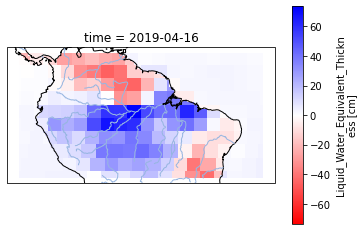

In [24]:
#GRACE-FO (different bounds than others because GRACE is over land)
lat_bnds, lon_bnds = [-18, 10], [275, 330] #degrees east for longitude
ds_GRACE_subset = ds_GRACE.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))
ds_GRACE_subset

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.RIVERS)
ds_GRACE_subset.lwe_thickness[171,:,:].plot(cmap = 'bwr_r') # 171 for 2019-04
plt.show()

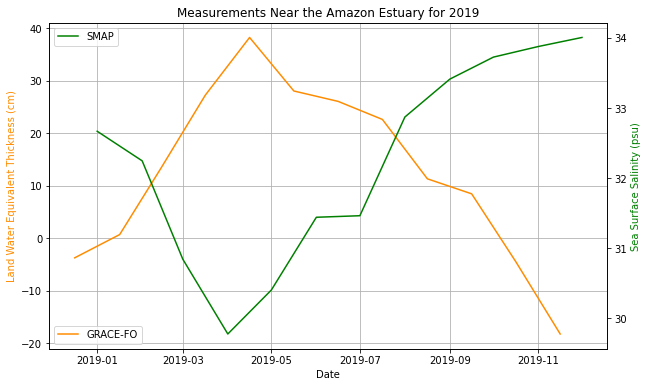

In [41]:
#plot SSS and LWE thickness

fig, ax1 = plt.subplots(figsize=[10,6])
#plot LWE thickness
ax1.plot(ds_GRACE_subset.time[167:179], ds_GRACE_subset.lwe_thickness[167:179,34,69], color = 'darkorange')

#plot SSS on secondary axis
ax2 = ax1.twinx()
ax2.plot(time_smap[45:], sss_smap_mean[45:], 'g-') # 45:

ax1.set_xlabel('Date')
ax2.set_ylabel('Sea Surface Salinity (psu)', color='g')
ax1.set_ylabel('Land Water Equivalent Thickness (cm)', color='darkorange')
ax2.legend(['SMAP'], loc='upper left')
ax1.legend(['GRACE-FO'], loc='lower left')
plt.title('Measurements Near the Amazon Estuary for 2019')
ax1.grid()
plt.show()

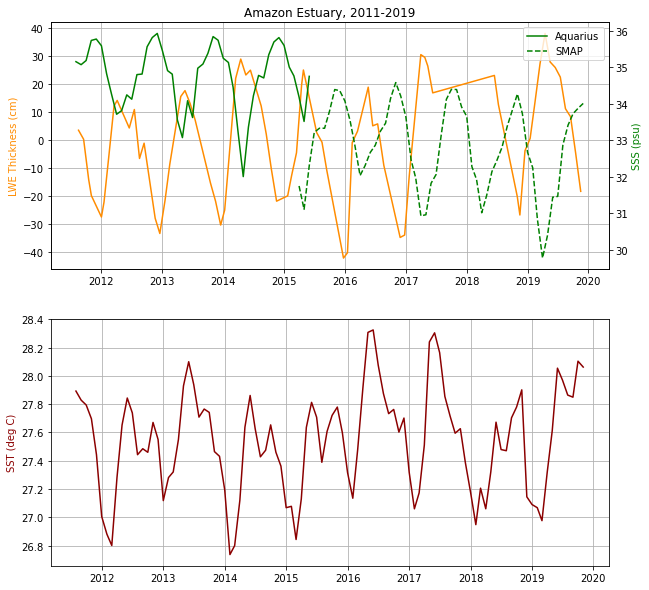

In [42]:
#Combined Subplots
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(211)
plt.title('Amazon Estuary, 2011-2019')
ax2 = ax1.twinx()
ax3 = plt.subplot(212)

#lwe thickness
ax1.plot(ds_GRACE_subset.time[107:179], ds_GRACE_subset.lwe_thickness[107:179,34,69], color = 'darkorange')
ax1.set_ylabel('LWE Thickness (cm)', color='darkorange')
ax1.grid()

#sea surface salinity
ax2.plot(time_Aq, sss_Aq_mean, 'g-')
ax2.plot(time_smap, sss_smap_mean, 'g--')
ax2.set_ylabel('SSS (psu)', color='g')
ax2.legend(['Aquarius', 'SMAP'], loc='upper right')

#sea surface temperature
ax3.plot(time_MODIS, sst_MODIS_mean, 'darkred')
ax3.set_ylabel('SST (deg C)', color='darkred')
ax3.grid()


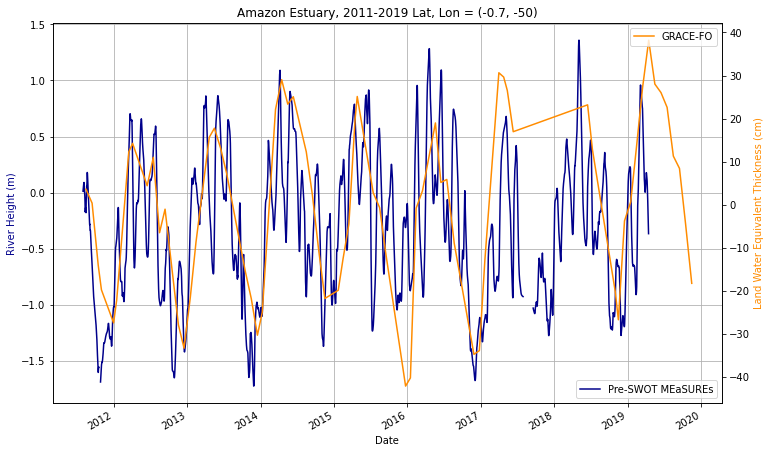

In [44]:
#plot river height and land water equivalent thickness

fig, ax1 = plt.subplots(figsize=[12,7])
#plot river height
ds_MEaSUREs.height[16,6689:9469].plot(color='darkblue')

#plot LWE thickness on secondary axis
ax2 = ax1.twinx()
ax2.plot(ds_GRACE_subset.time[107:179], ds_GRACE_subset.lwe_thickness[107:179,34,69], color = 'darkorange')

ax1.set_xlabel('Date')
ax2.set_ylabel('Land Water Equivalent Thickness (cm)', color='darkorange')
ax1.set_ylabel('River Height (m)', color='darkblue')
ax2.legend(['GRACE-FO'], loc='upper right')
ax1.legend(['Pre-SWOT MEaSUREs'], loc='lower right')

plt.title('Amazon Estuary, 2011-2019 Lat, Lon = (-0.7, -50)')
ax1.grid()
plt.show()